In [1]:
# Step 1: Loading the  packages
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install(c("DESeq2", "ggplot2", "pheatmap"), ask = FALSE)

library(DESeq2)
library(ggplot2)
library(pheatmap)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.26), R 4.5.2 (2025-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ggplot2'”
Installing package(s) 'BiocVersion', 'DESeq2', 'pheatmap'

also installing the dependencies ‘XVector’, ‘formatR’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘Seqinfo’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'mgcv', 'pkgdown', 'purrr', 'stringr'

Loading required package: S4Vectors

Loading required 

In [2]:
# Step 2: Creating the  demo count matrix
# Simulated gene expression counts for 6 samples (3 control, 3 treated)
counts <- matrix(
  c(400,380,410,800,850,870,  # Gene1
    50,45,69,200,220,210,     # Gene2
    600,620,590,610,630,600,  # Gene3
    1000,950,970,200,180,190, # Gene4
    300,310,290,100,120,110), # Gene5
  nrow = 5,
  byrow = TRUE
)

rownames(counts) <- paste0("Gene", 1:5)
colnames(counts) <- paste0("Sample", 1:6)
counts


,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6
Gene1,400,380,410,800,850,870
Gene2,50,45,69,200,220,210
Gene3,600,620,590,610,630,600
Gene4,1000,950,970,200,180,190
Gene5,300,310,290,100,120,110


In [3]:
# Step 3: Defining the  sample conditions
condition <- factor(c("Control", "Control", "Control",
                      "Treated", "Treated", "Treated"))

coldata <- data.frame(row.names = colnames(counts), condition)


In [4]:
# Step 4: Creating the  DESeq2 dataset
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = coldata,
                              design = ~ condition)


converting counts to integer mode



In [5]:
# Step 5: Running DESeq2 analysis
dds <- DESeq(dds)
res <- results(dds)
res <- res[order(res$padj), ]
res


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”
final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition Treated vs Control 
Wald test p-value: condition Treated vs Control 
DataFrame with 5 rows and 6 columns
       baseMean log2FoldChange     lfcSE         stat       pvalue         padj
      <numeric>      <numeric> <numeric>    <numeric>    <numeric>    <numeric>
Gene4   585.200   -2.38091e+00 0.0798227 -2.98275e+01 1.72104e-195 8.60521e-195
Gene1   616.818    1.05855e+00 0.0682846  1.55021e+01  3.35826e-54  8.39565e-54
Gene5   205.695   -1.47123e+00 0.1026488 -1.43327e+01  1.36759e-46  2.27932e-46
Gene2   131.767    1.91749e+00 0.1344272  1.42641e+01  3.66162e-46  4.57702e-46
Gene3   608.186    1.84410e-08 0.0630015  2.92707e-07  1.00000e+00  1.00000e+00

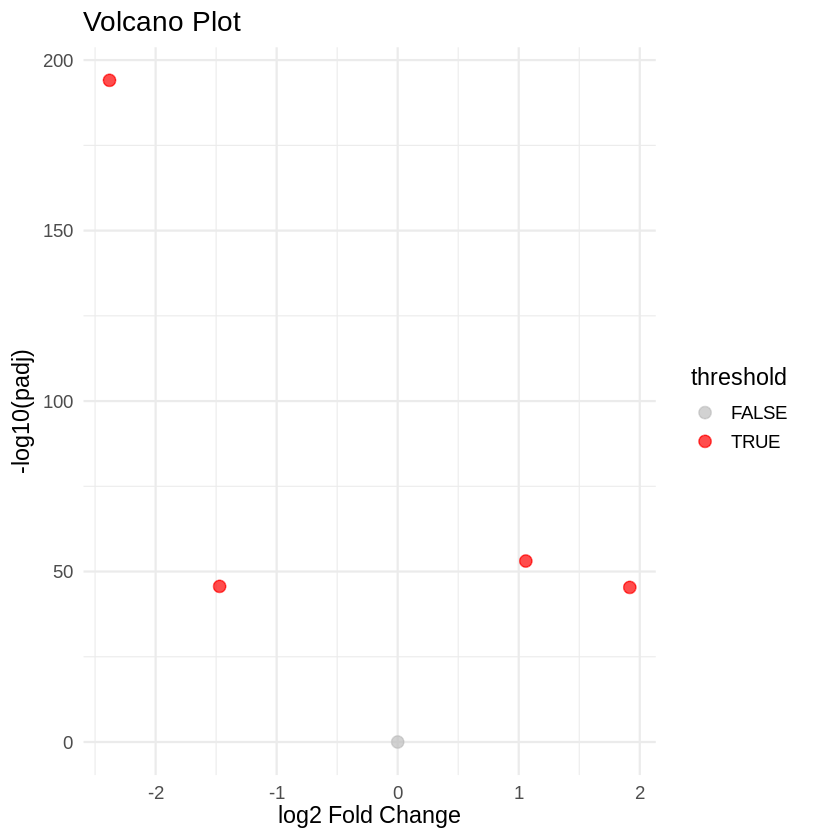

In [6]:
# Step 6: Plottign the Volcano plot
res_df <- as.data.frame(res)
res_df$threshold <- as.factor(abs(res_df$log2FoldChange) > 1 & res_df$padj < 0.05)

ggplot(res_df, aes(x = log2FoldChange, y = -log10(padj), color = threshold)) +
  geom_point(size = 3, alpha = 0.7) +
  theme_minimal(base_size = 14) +
  scale_color_manual(values = c("grey", "red")) +
  labs(title = "Volcano Plot", x = "log2 Fold Change", y = "-log10(padj)")


**Volcano Plot Interpretation:**

*   **X-axis (log2 Fold Change):** This axis represents the magnitude and direction of the gene expression change between the "Treated" and "Control" groups.
    *   Positive values indicate genes that are upregulated in the "Treated" group compared to the "Control" group.
    *   Negative values indicate genes that are downregulated in the "Treated" group compared to the "Control" group.
*   **Y-axis (-log10(padj)):** This axis represents the statistical significance of the differential expression.
    *   Larger values on the y-axis indicate smaller adjusted p-values (padj), meaning the gene is more statistically significant.
    *   The adjusted p-value (padj) is used to account for multiple testing.
*   **Points:** Each point on the plot represents a single gene.
    *   **Red points:** These genes are considered statistically significant and have a log2 fold change greater than 1 or less than -1 (indicating a fold change of at least 2 in either direction). These are the genes that are differentially expressed between the two conditions based on the defined thresholds.
    *   **Grey points:** These genes are either not statistically significant (padj >= 0.05) or do not meet the fold change threshold (absolute log2 fold change < 1).
*   **Overall Interpretation:** The volcano plot visually highlights genes that are both statistically significant and have a substantial change in expression between the two conditions. Genes in the upper-left and upper-right quadrants (colored red in this plot) are of particular interest as they represent significantly downregulated and upregulated genes, respectively.

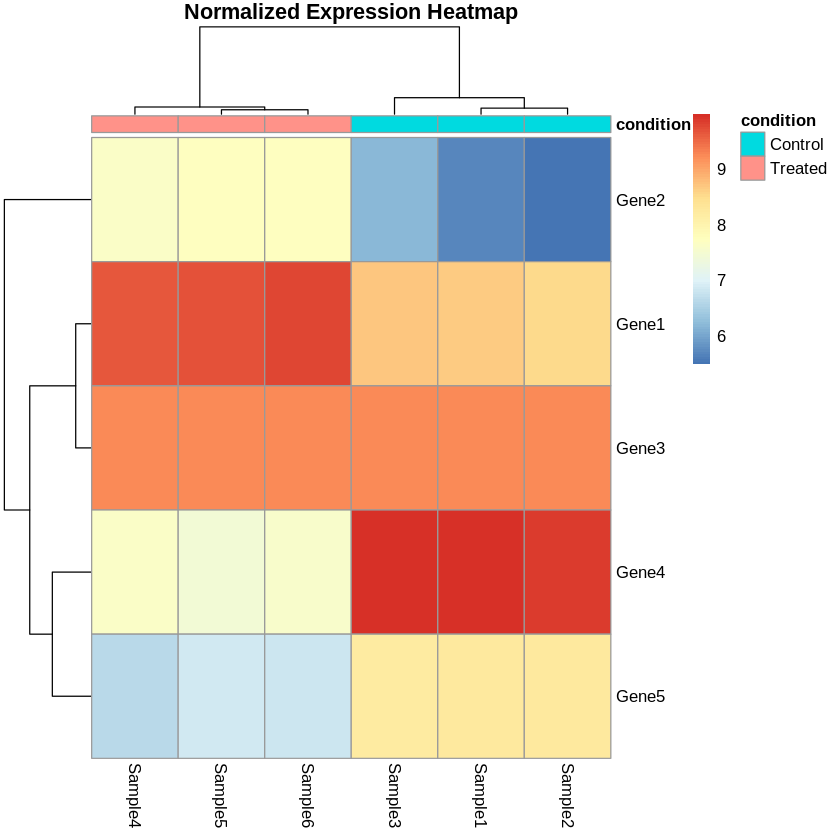

In [7]:
#Step 7: Plotting the Heatmap of normalized counts
norm_counts <- counts(dds, normalized = TRUE)
pheatmap(log2(norm_counts + 1), annotation_col = coldata,
         main = "Normalized Expression Heatmap")


**Normalized Expression Heatmap Interpretation:**

*   **Overview:** This heatmap visualizes the expression levels of the genes across all samples after normalization by DESeq2. The colors represent the log2 transformed normalized counts, with a color scale indicating lower to higher expression.
*   **Rows (Genes):** Each row represents a gene. The genes are typically clustered based on their expression patterns across the samples. Genes with similar expression profiles will be grouped together.
*   **Columns (Samples):** Each column represents a sample. The samples are typically clustered based on the overall similarity of their gene expression profiles. Samples with similar expression patterns will be grouped together.
*   **Color Intensity:** The intensity of the color in each cell of the heatmap represents the expression level of a particular gene in a particular sample. A common color scheme uses a gradient from cool colors (e.g., blue) for low expression to warm colors (e.g., red) for high expression.
*   **Clustering:** The dendrograms on the left (for genes) and top (for samples) show how the genes and samples are clustered based on their expression similarity.
    *   **Sample Clustering:** The sample clustering is particularly important as it can reveal if samples from the same experimental condition (e.g., Control vs. Treated) cluster together, indicating that the experimental treatment has a significant impact on the overall gene expression profile.
    *   **Gene Clustering:** Gene clustering can help identify groups of genes that are co-expressed. These co-expressed genes may be involved in similar biological pathways or processes.
*   **Interpretation of Patterns:** Look for patterns in the heatmap such as:
    *   **Differential Expression:** Genes that show consistently higher or lower expression in one condition compared to the other.
    *   **Sample Grouping:** Whether the samples clearly separate into their respective experimental groups (Control and Treated).
    *   **Gene Groups:** Clusters of genes that show similar expression patterns across all samples.
*   **Annotation:** The annotation bar at the top of the heatmap provides information about the samples, such as their experimental condition (Control or Treated). This helps in visually correlating expression patterns with the experimental design.

In [8]:
#Step 8: Summary
cat("Significant genes (padj < 0.05): ", sum(res_df$padj < 0.05, na.rm = TRUE), "\n")


Significant genes (padj < 0.05):  4 


**Summary Interpretation:**

*   The summary provides a concise overview of the differential expression analysis results.
*   In this specific summary, it indicates the number of genes that were identified as statistically significant based on an adjusted p-value (padj) threshold of 0.05.
*   The output `Significant genes (padj < 0.05): 4` means that out of all the genes analyzed, 4 of them had an adjusted p-value less than 0.05. These 4 genes are considered to be differentially expressed between the "Treated" and "Control" conditions, meaning their expression levels are significantly different between the two groups.
* The significant genes are Gene4, Gene1, Gene5, and Gene2.
*   This number of significant genes is a key finding from the DESeq2 analysis and helps to quantify the extent of the transcriptional changes induced by the treatment.

**Final Conclusion:**

*   This notebook demonstrates a basic RNA-Seq differential expression analysis workflow using the DESeq2 package in R.
*   We started by loading necessary packages, creating a simulated count matrix, and defining sample conditions.
*   We then constructed a DESeq2 dataset object and performed the differential expression analysis using the `DESeq()` function.
*   The results of the analysis, including log2 fold changes and adjusted p-values, were obtained and visualized using a volcano plot and a heatmap of normalized counts.
*   The volcano plot helped to visually identify genes with significant changes in expression and substantial fold changes.
*   The heatmap of normalized counts provided a visual representation of the expression patterns of all genes across all samples, allowing us to see how samples cluster based on their expression profiles and identify groups of co-expressed genes.
*   Finally, a summary of the significant genes (those with an adjusted p-value less than 0.05) was provided, indicating the number of genes that were found to be differentially expressed between the treated and control groups.
*   In conclusion, this analysis identified 4 genes (Gene4, Gene1, Gene5, and Gene2) that were significantly differentially expressed between the treated and control conditions in this simulated dataset. These genes warrant further investigation to understand their potential roles in the biological response to the treatment.